In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd

shape = (100, 16)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input

In [2]:
reg = LinearRegression().fit(X, y)
reg.score(X, y), reg.coef_

(0.9993316174977624,
 array([0.98231329, 1.00293103, 1.01089872, 0.99780244, 1.01754801,
        1.01399901, 1.01117047, 1.0116978 , 0.97996713, 1.0128416 ,
        1.00504136, 1.01933667, 0.98243754, 0.98514289, 1.0177332 ,
        1.00559587]))

In [6]:
def divisive_shap_approx(Xs, y, model, beta, gamma_n, gamma_d, num_splits = 2):
    """Xs is a dictionary:
    {
        party1: X1,
        party2: X2,
        ...
    }

    where each X is a dataframe (to conserve columns)
    """
    parties_to_split = {}
    for party, X in Xs.items():
        if X.shape[1] > np.emath.logn(beta, n):
            parties_to_split[party] = X
        else:
            shap = shapley_true(X.to_numpy(), y, model)
            shap = shap*gamma_n/gamma_d
            results[party].append([X, shap])

    if len(parties_to_split) > 0:
        Xs_split = partition(parties_to_split, num_splits)
        gamma_n * np.mean([value(X.to_numpy(), y, model) for X in parties_to_split.values()])
        gamma_d * np.mean([sum([value(Xi.to_numpy(), y, model) for Xi in Xs]) for Xs in Xs_split.values()])

        for i in range(num_splits):
            divisive_shap_approx({party:Xs[i] for party, Xs in Xs_split.items()}, 
                                          y, 
                                          model,
                                          beta,
                                          gamma_n , 
                                          gamma_d)

def value(X, y, model):
    if X.size == 0:
        return 0
    else:
        reg = model.fit(X, y)
        return reg.score(X, y)
        

def findsubsets(s, n):
    return list(itertools.combinations(s, n))


def shapley_true(X, y, model):
    """Returns true shapley value of each feature (numpy array)"""
    N = X.shape[1]
    shap = np.zeros(N)
    for i in range(N):
        other_features = set(range(N))
        other_features.remove(i)
        subsets = [subset for j in range(N) for subset in findsubsets(other_features, j)]
        for subset in subsets:
            coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
            shap[i] += coeff*(value(X[:,list(subset) + [i]], y, model)-value(X[:, list(subset)], y, model))
    return np.array(shap)

def partition(Xs, num_splits):
    """Returns dict of lists:
    {
        party1: [X1, X2, ...],
        party2: [X1, X2, ...],
        ...
    }
    """

    return {party: [x.T for x in train_test_split(X.T, test_size=0.5)] for party, X in Xs.items()}

def main(Xs, y, model, beta):

    # Run algorithm
    divisive_shap_approx(Xs, y, model, beta, 1, 1)

    # Concatenate results
    results_concat = {}
    for party, leafs in results.items():
        X = pd.DataFrame()
        shaps = []
        for res in leafs:
            X = pd.concat([X, res[0]], axis = 1)
            shaps = np.concatenate((shaps, res[1]))
        results_concat[party] = [X, shaps]

    # Scale results
    results_scaled = {party:[shaps[0], shaps[1] * value(shaps[0].to_numpy(),y,model)] for party, shaps in results_concat.items()}
    # sum to 1
    shap_sum = sum([s for shaps in results_scaled.values() for s in shaps[1]])
    for party, shaps in results_scaled.items():
        results_scaled[party][1] /= shap_sum


    # Reorder results:
    for party, shaps in results_scaled.items():
        order = [shaps[0].columns.get_loc(feature) for feature in Xs[party].columns]
        results_scaled[party] = results_scaled[party][1][order]

    return results_scaled


In [47]:
shape = (1000, 128)
num_parties = 4
n = shape[1]//num_parties

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5


scales = [[10,3], [4, 4], [2, 6], [3, 0.2]]
#for scalei, i in enumerate(range(0,shape[1], n)):
#    X[:,i] *= scales[scalei][0]
#    X[:,i+1] = X[:,i+1] * scales[scalei][1]
coeffs = np.ones(shape[1])
for scalei, i in enumerate(range(0,shape[1], n)):
    coeffs[i] = scales[scalei][0]
    coeffs[i + 1] = scales[scalei][1]


#y = np.sum(X, axis=1) # Sum of each row
y = np.dot(X, coeffs)

X = X + np.random.normal(0, .1, shape) # Add noise to input
X = pd.DataFrame(X)

Xs = {}

for i in range(num_parties):
 Xs["p" + str(i)] = X.iloc[:,i*n:(i+1)*n]

results = {key:[] for key in Xs.keys()}
results = main(Xs, y, LinearRegression(), n**(1/np.sqrt(n)))

#plt.hist(shap)
#plt.show()

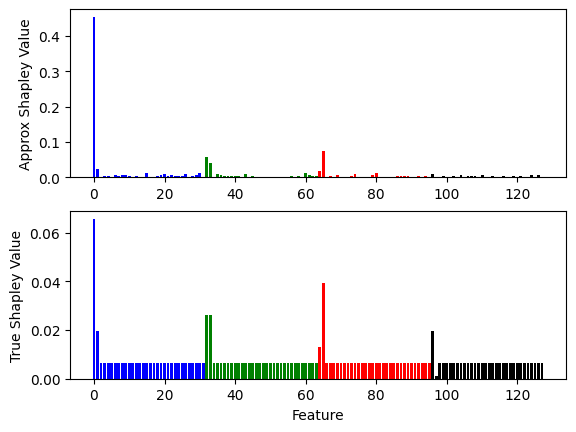

In [59]:
fig, (ax1, ax2) = plt.subplots(2)


allshaps = [s for shaps in results.values() for s in shaps]
color = np.repeat(["blue","green","red","black"],n)
ax1.bar(range(shape[1]), allshaps, color = color)
ax1.set_ylabel("Approx Shapley Value")


true_shap = coeffs / sum(coeffs)
ax2.bar(range(shape[1]), true_shap, color = color)
ax2.set_ylabel("True Shapley Value")
ax2.set_xlabel("Feature")
plt.show()